In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.decomposition import PCA
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, Flatten, Conv1D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from scipy.signal import lfilter
import solverFunctions as sf
import analysisFunctions as af
from scipy.interpolate import LinearNDInterpolator

In [36]:
def GetEncoder1(n_latent,input_shape):
    input_imag = Input(shape=input_shape, name='encoder_input')
    x = Flatten()(input_imag)
    latent = Dense(n_latent)(x)
    encoder = Model(input_imag,latent,name="encoder")
    return encoder

def GetDecoder(n_latent,input_shape):
    input_latent = Input(shape=(n_latent,))
    x = Dense(input_shape[0]*input_shape[1]*input_shape[2],use_bias=False)(input_latent)
    x = Reshape((input_shape[0],input_shape[1],input_shape[2]))(x)
    decoder = Model(input_latent,x,name="decoder")
    return decoder

def GetAE(input_shape,n_latent):
    input_imag = Input(shape=input_shape, name='encoder_input')
    encoder = GetEncoder1(n_latent,input_shape)
    decoder = GetDecoder(n_latent,input_shape)
    model = Model(input_imag, decoder(encoder(input_imag)))
    
    return model, encoder, decoder

array([2.67777417, 2.05892346, 1.59575849, ..., 2.24635836, 1.35578867,
       1.9493145 ])

In [5]:
def getXtrain(order_bc,continuos=False):
    if continuos:
        con_str = "C"
    else:
        con_str = "DC"
    u = np.load(r"DataDC/dataset"+con_str+"_u_30_1_"+str(order_bc)+".npy")
    v = np.load(r"DataDC/dataset"+con_str+"_v_30_1_"+str(order_bc)+".npy")
    p = np.load(r"DataDC/dataset"+con_str+"_p_30_1_"+str(order_bc)+".npy")
    u_train = (u[:,1:,1:-1]+u[:,:-1,1:-1])/2
    u_train = np.expand_dims(u_train,axis=-1)
    v_train = (v[:,1:-1,1:]+v[:,1:-1,:-1])/2
    v_train = np.expand_dims(v_train,axis=-1)
    p_train = p
    p_train = np.expand_dims(p_train,axis=-1)
    x_train = np.concatenate([u_train,v_train,p_train],axis=3)
    return x_train

x_train = np.concatenate([getXtrain(2),getXtrain(3),getXtrain(5),getXtrain(4,True)],axis=0)
# x_train2 = getXtrain(2)
# x_train5 = getXtrain(5)
# xRe_max = np.max(np.sqrt(x_train[:,:,:,0]**2+x_train[:,:,:,1]**2),axis=(1,2))
# xRe_mean = np.mean(np.sqrt(x_train[:,:,:,0]**2+x_train[:,:,:,1]**2),axis=(1,2))
x_train.shape

(19067, 30, 30, 3)

In [6]:
np.isnan(x_train).any()

False

In [72]:
n_image = 30
n_latent = 10
# model_l,encoder_l,decoder_l = GetAE((n_image,n_image,3),n_latent)
optimizer = tf.keras.optimizers.Adam(0.0001)
model_l.compile(loss='mse', optimizer=optimizer,metrics=['mse'])
history_l = model_l.fit(x_train,x_train,epochs=50,batch_size=32,validation_split=0.2,shuffle=True)

Epoch 1/50
477/477 [==============================] - 2s 3ms/step - loss: 0.4074 - mse: 0.4074 - val_loss: 0.4045 - val_mse: 0.4045
Epoch 2/50
477/477 [==============================] - 1s 3ms/step - loss: 0.4060 - mse: 0.4060 - val_loss: 0.4046 - val_mse: 0.4046
Epoch 3/50
477/477 [==============================] - 1s 3ms/step - loss: 0.4066 - mse: 0.4066 - val_loss: 0.4056 - val_mse: 0.4056
Epoch 4/50
477/477 [==============================] - 2s 3ms/step - loss: 0.4058 - mse: 0.4058 - val_loss: 0.4061 - val_mse: 0.4061
Epoch 5/50
477/477 [==============================] - 2s 3ms/step - loss: 0.4069 - mse: 0.4069 - val_loss: 0.4068 - val_mse: 0.4068
Epoch 6/50
477/477 [==============================] - 2s 3ms/step - loss: 0.4057 - mse: 0.4057 - val_loss: 0.4062 - val_mse: 0.4062
Epoch 7/50
477/477 [==============================] - 2s 3ms/step - loss: 0.4062 - mse: 0.4062 - val_loss: 0.4081 - val_mse: 0.4081
Epoch 8/50
477/477 [==============================] - 1s 3ms/step - loss: 0.

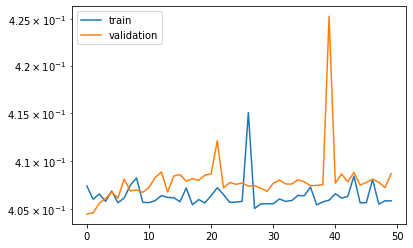

In [73]:
plt.plot(history_l.history['mse'])
plt.plot(history_l.history['val_mse'])
plt.gca().set_yscale("log")
plt.legend(["train","validation"])

100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


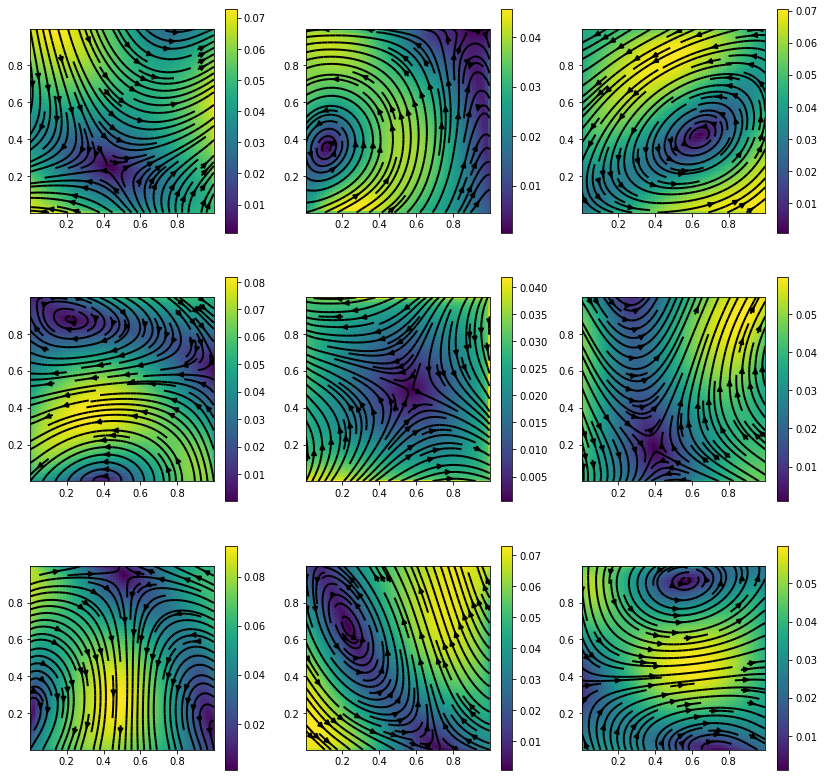

In [163]:
eig = decoder.trainable_variables[0].numpy().reshape(n_latent,30,30,3)
af.PlotX(3,3,eig,prob)

100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


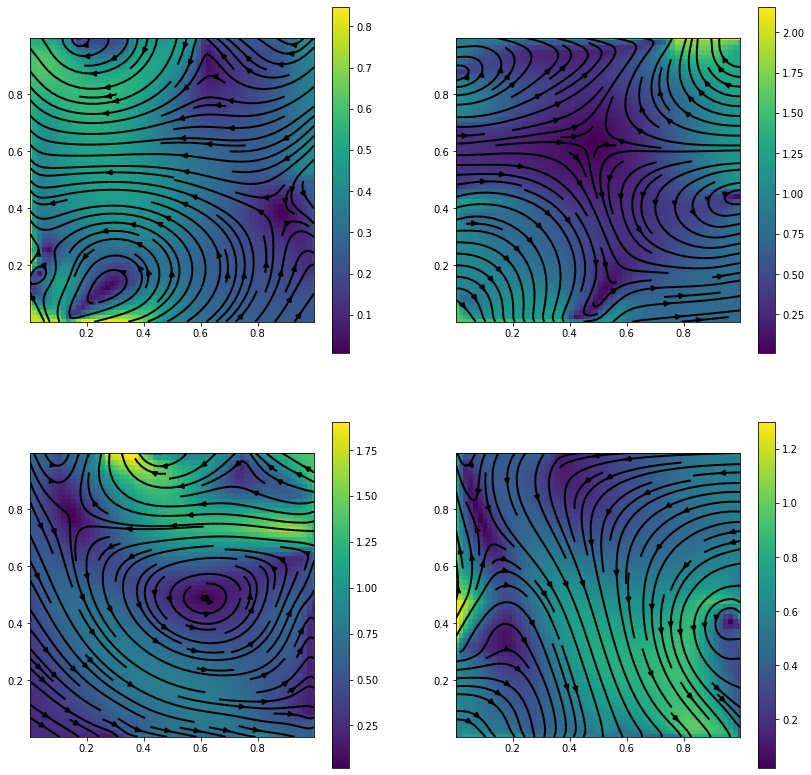

100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


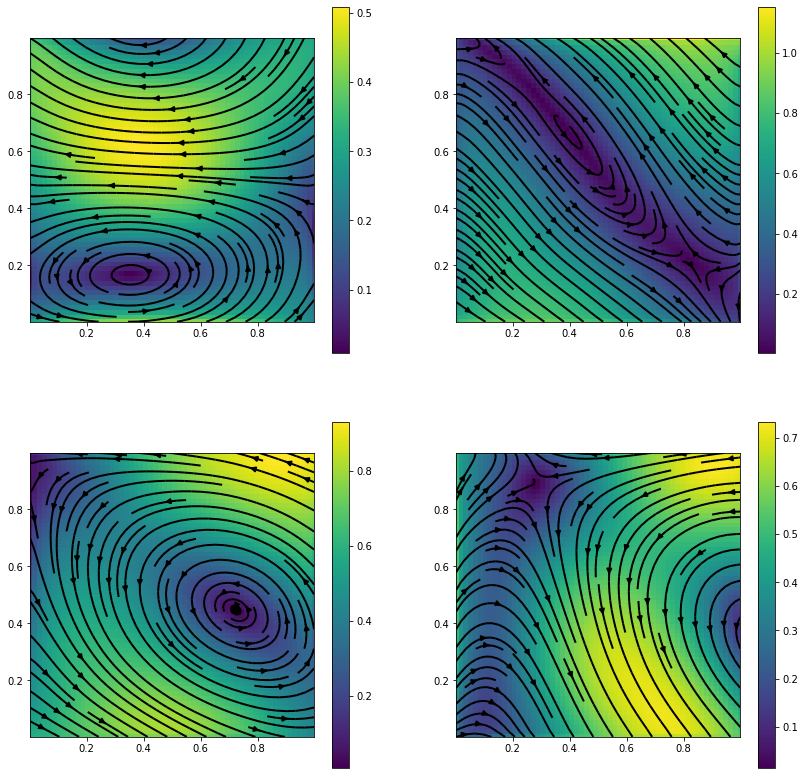

In [180]:
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
x_train = x_train[indexes]
x_sample = x_train[7007:]
x_recon = model(x_sample).numpy()
af.PlotX(2,2,x_sample,prob)
af.PlotX(2,2,x_recon,prob)

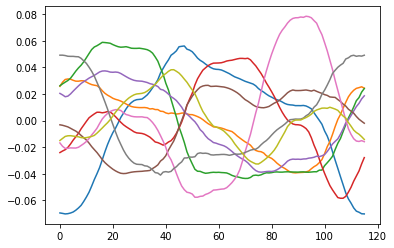

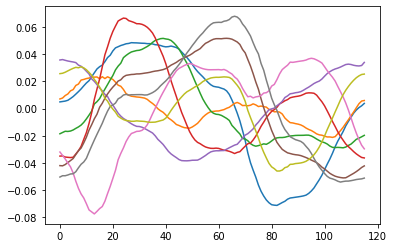

In [166]:
def GetBoundary(x):
    if (len(x.shape)==4):
        u_n = x[:,:,:,0]
        v_n = x[:,:,:,1]
        u_bc = np.concatenate([u_n[:,:-1,0],u_n[:,-1,:-1],u_n[:,1:,-1][:,::-1],u_n[:,0,1:][:,::-1]],axis=-1)
        v_bc = np.concatenate([v_n[:,:-1,0],v_n[:,-1,:-1],v_n[:,1:,-1][:,::-1],v_n[:,0,1:][:,::-1]],axis=-1)
    else:
        u_n = x[:,:,0]
        v_n = x[:,:,1]
        u_bc = np.concatenate([u_n[:-1,0],u_n[-1,:-1],u_n[1:,-1][::-1],u_n[0,1:][::-1]])
        v_bc = np.concatenate([v_n[:-1,0],v_n[-1,:-1],v_n[1:,-1][::-1],v_n[0,1:][::-1]])
    return u_bc,v_bc

u_bc,v_bc = GetBoundary(eig)
plt.plot(np.transpose(u_bc))
plt.show()
plt.plot(np.transpose(v_bc))
plt.show()

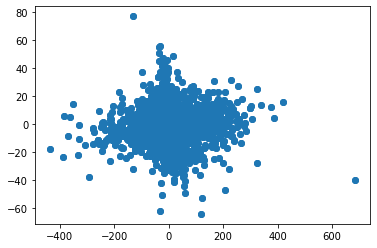

In [177]:
mean = encoder(x_train[:]).numpy()
# plt.scatter(mean[:,0],mean[:,1])
pca = PCA(n_components=2)
pca_fit = pca.fit(mean)
points = pca_fit.transform(mean)
plt.scatter(points[:,0],points[:,1])


Epoch 1/2000
149/149 [==============================] - 5s 31ms/step - loss: 1.4842 - mse: 1.4842
Epoch 2/2000
149/149 [==============================] - 2s 13ms/step - loss: 1.4891 - mse: 1.4891
Epoch 3/2000
149/149 [==============================] - 4s 30ms/step - loss: 1.4793 - mse: 1.4793
Epoch 4/2000
149/149 [==============================] - 2s 13ms/step - loss: 1.4875 - mse: 1.4875
Epoch 5/2000
149/149 [==============================] - 4s 30ms/step - loss: 1.4760 - mse: 1.4760
Epoch 6/2000
149/149 [==============================] - 2s 14ms/step - loss: 1.5028 - mse: 1.5028
Epoch 7/2000
149/149 [==============================] - 2s 13ms/step - loss: 1.5076 - mse: 1.5076
Epoch 8/2000
149/149 [==============================] - 2s 15ms/step - loss: 1.5016 - mse: 1.5016
Epoch 9/2000
149/149 [==============================] - 4s 29ms/step - loss: 1.4726 - mse: 1.4726
Epoch 10/2000
149/149 [==============================] - 2s 14ms/step - loss: 1.4981 - mse: 1.4981
Epoch 11/2000
149/1

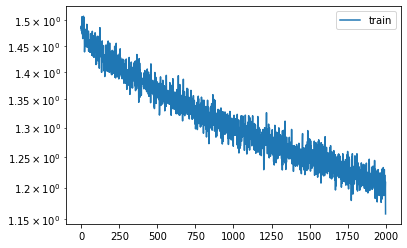

In [15]:
n_image = 30
n_latent = 10
# model,encoder,decoder = GetModelAENL(n_latent,(n_image,n_image,3))
# optimizer = tf.keras.optimizers.Adam(0.00001)
# model.compile(loss='mse', optimizer=optimizer,metrics=['mse'])
checkpoint_filepath = 'MLmodels/NS_10DAE_NLv1.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True)
history_nl = model.fit(x_train,x_train,epochs=2000,batch_size=128,shuffle=True,callbacks=[model_checkpoint_callback])
plt.plot(history_nl.history['mse'])
plt.gca().set_yscale("log")
plt.legend(["train","validation"])

In [79]:
def GetEncoderNL(n_latent,image):
    input_e = Input(image)
    x = Flatten()(input_e)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    mean = Dense(n_latent)(x)
    log_var = Dense(n_latent)(x)
    encoder = Model(input_e,[mean,log_var])
    return encoder

def GetEncoderNL_AE(n_latent,image):
    input_e = Input(image)
    x = Flatten()(input_e)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    mean = Dense(n_latent)(x)
    encoder = Model(input_e,mean)
    return encoder

def GetDecoderNL(n_latent,image):
    input_d = Input(n_latent)
    x = Dense(100,activation='sigmoid')(input_d)
    x = BatchNormalization()(x)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(image[0]*image[1]*image[2])(x)
    out_d = Reshape((image[0],image[1],image[2]))(x)
    decoder = Model(input_d,out_d)
    return decoder

def GetEncoderNL2(n_latent,image):
    input_e = Input(image)
    x = Conv2D(8,10,activation="sigmoid",strides=(2,2))(input_e)
    x = BatchNormalization()(x)
    x = Conv2D(16,10,activation="sigmoid",strides=(2,2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    mean = Dense(n_latent)(x)
    log_var = Dense(n_latent)(x)
    encoder = Model(input_e,[mean,log_var])
    return encoder

def GetDecoderNL2(n_latent,image):
    input_d = Input(n_latent)
    x = Dense(20,activation='sigmoid')(input_d)
    x = BatchNormalization()(x)
    x = Dense(20,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(image[0]*image[1])(x)
    out_d = Reshape((image[0],image[1],1))(x)
    decoder = Model(input_d,out_d)
    return decoder

def GetModelAENL(n_latent,image):
    input_e = Input(image)
    encoder = GetEncoderNL_AE(n_latent,image)
    decoder = GetDecoderNL(n_latent,image)
    model = Model(input_e,decoder(encoder(input_e)))
    return model,encoder,decoder

class ModelVAE_NL(Model):
    
    def __init__(self,n_latent,input):
        super(ModelVAE_NL,self).__init__()
        self.n_latent = n_latent
        self.encoder = GetEncoderNL(n_latent,input)
        self.decoder = GetDecoderNL(n_latent,input)
        
    def sample(self,z_mean,z_logsigma):
        batch, latent_dim = z_mean.shape
        epsilon = tf.random.normal(shape=(batch, latent_dim))
        z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
        return z
    
    def encode(self,x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean,log_var)
        return z, mean, log_var
        
    def decode(self,z):
        x_r = self.decoder(z)
        return x_r
        
    def call(self,x):
        z, mean, log_var = self.encode(x)
        x_r = self.decode(z)
        return x_r, mean, log_var
    
    def reconstruct(self,x):
        mean,_ = self.encoder(x)
        x_r = self.decoder(mean)
        return x_r
    
class ModelVAE_NL2(Model):
    
    def __init__(self,n_latent,n_input):
        super(ModelVAE_NL2,self).__init__()
        self.n_latent = n_latent
        self.encoder = GetEncoderNL2(n_latent,(n_input,n_input,1))
        self.decoder = GetDecoderNL2(n_latent,(n_input,n_input,1))
        
    def sample(self,z_mean,z_logsigma):
        batch, latent_dim = z_mean.shape
        epsilon = tf.random.normal(shape=(batch, latent_dim))
        z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
        return z
    
    def encode(self,x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean,log_var)
        return z, mean, log_var
        
    def decode(self,z):
        x_r = self.decoder(z)
        return x_r
        
    def call(self,x):
        z, mean, log_var = self.encode(x)
        x_r = self.decode(z)
        return x_r, mean, log_var
    
    def reconstruct(self,x):
        mean,_ = self.encoder(x)
        x_r = self.decoder(mean)
        return x_r
    
# def vae_loss_function(x, x_recon, mu, logsigma,kl_weight,A,fd_weight):
#     latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
#     reconstruction_loss = tf.reduce_mean(tf.square(x-x_recon), axis=(1,2,3))
#     fd_loss = tf.reduce_mean(tf.square(tf.matmul(A,tf.reshape(x_recon,\
#         shape=(x_recon.shape[0],x_recon.shape[1]*x_recon.shape[2],1)))),axis=(1,2))
#     vae_loss = kl_weight * latent_loss + reconstruction_loss + fd_weight * fd_loss
#     return vae_loss,reconstruction_loss,latent_loss,fd_loss

def vae_loss_function(x, x_recon, mu, logsigma,kl_weight):
    latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.square(x-x_recon), axis=(1,2,3))
    vae_loss = kl_weight * latent_loss + reconstruction_loss
    return vae_loss,reconstruction_loss,latent_loss

@tf.function
def train_step_VAE(modelVAE,optimizer,images,kl_weight):
    with tf.GradientTape() as tape:
        
        (images_r, mu, log_vat) = modelVAE(images)
        images = tf.cast(images,tf.float32)
        loss,r_loss,l_loss = vae_loss_function(images,images_r, mu, log_vat,kl_weight)

    grads = tape.gradient(loss,modelVAE.trainable_variables)
    optimizer.apply_gradients(zip(grads,modelVAE.trainable_variables))
    return loss,r_loss,l_loss

class History():
    def __init__(self,n):
        self.loss = np.zeros(n)
        self.r_loss = np.zeros(n)
        self.l_loss = np.zeros(n)
        self.fd_loss = np.zeros(n)
        
    def add(self,history):
        self.loss = np.concatenate([self.loss,history.loss],axis=0)
        self.r_loss = np.concatenate([self.r_loss,history.r_loss],axis=0)
        self.l_loss = np.concatenate([self.l_loss,history.l_loss],axis=0)
        self.fd_loss = np.concatenate([self.fd_loss,history.fd_loss],axis=0)

def train_VAE(modelVAE,optimizer,x_train,n_epochs,n_batch,kl_weight=0.005,modelPath=None):
    n_steps = n_epochs*len(range(0,x_train.shape[0],n_batch))
    history = History(n_steps)
    index = 0
    loss_min = np.inf
    for epoch in range(n_epochs):
        i = np.arange(x_train.shape[0])
        np.random.shuffle(i)
        x_train = x_train[i,:,:,:]
#         x_train_shuffled = tf.cast(x_train_shuffled,tf.float32)
        loss_epoch = np.zeros((x_train.shape[0]))

        for batch in range(0,x_train.shape[0],n_batch):
            loss,r_loss,l_loss = train_step_VAE(modelVAE,optimizer,x_train[batch:batch+n_batch],kl_weight)
            history.loss[index] = tf.reduce_mean(loss)
            history.r_loss[index] = tf.reduce_mean(r_loss)
            history.l_loss[index] = tf.reduce_mean(l_loss)
            loss_epoch[batch:batch+loss.shape[0]] = loss
            # history.fd_loss[index] = tf.reduce_mean(fd_loss)
            
            print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}".format(epoch+1,n_epochs, 100*batch/x_train.shape[0],history.loss[index]),end="\t") #
            index+=1
            
        print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}".format(epoch+1,n_epochs, 100,loss_epoch.mean()),end="\n")
        if (modelPath!=None) and (loss_epoch.mean()<loss_min):
            modelVAE.save_weights(modelPath)
            
    return history

In [80]:
n_batch = 64
n_epochs = 200
kl_weight = 0.00005 #kl_weight = 0.0005
n_latent = 10
input_shape = x_train[0].shape
lr = 0.0002

# modelVAE = ModelVAE_NL(n_latent,input_shape)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

lhistory_part = train_VAE(modelVAE,optimizer,x_train,n_epochs,n_batch,kl_weight,"MLmodels/NS_10D_NLv4")
print()
if ('lhistory' in locals()):
    lhistory.add(lhistory_part)
    print("add")
else:
    lhistory = lhistory_part
    print("define")

1/200 epochs - 100%; loss = 2.66384							
2/200 epochs - 100%; loss = 2.55966													
3/200 epochs - 100%; loss = 2.51926											
4/200 epochs - 100%; loss = 2.46442														
5/200 epochs - 100%; loss = 2.42617											
6/200 epochs - 100%; loss = 2.39233													
7/200 epochs - 100%; loss = 2.37013												
8/200 epochs - 100%; loss = 2.32974														
9/200 epochs - 100%; loss = 2.32573								
10/200 epochs - 100%; loss = 2.28939													
11/200 epochs - 100%; loss = 2.29844											
12/200 epochs - 100%; loss = 2.2432												
13/200 epochs - 100%; loss = 2.23014									
14/200 epochs - 100%; loss = 2.2409													
15/200 epochs - 100%; loss = 2.22743										
16/200 epochs - 100%; loss = 2.19967															
17/200 epochs - 100%; loss = 2.19976										
18/200 epochs - 100%; loss = 2.20337											
19/200 epochs - 100%; loss = 2.1762																
20/200 epochs - 100%; loss = 2.16219												
21/200 epochs - 100%; loss = 2.15813	

In [84]:
# n_latent = 10
# input_shape = x_train[0].shape
# modelVAE = ModelVAE_NL(n_latent,input_shape)
# modelVAE.save_weights("MLmodels/NS_10D_NLv3")
# modelVAE.summary()
# del lhistory
CalcMSE(x_train,modelVAE)

NameError: name 'CalcMSE' is not defined

In [90]:
n_latent = 10
input_shape = x_train[0].shape
modelVAE2 = ModelVAE_NL(n_latent,input_shape)
modelVAE2.load_weights("MLmodels/NS_10D_NLv4")

Text(0, 0.5, 'loss')

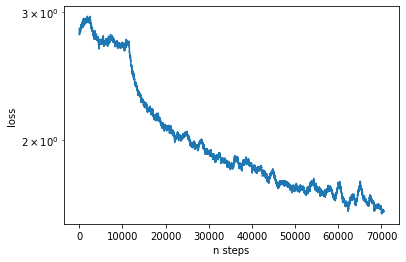

In [81]:
n_filt = 1000
a = np.ones(n_filt)
h = lfilter(a,a.sum(),lhistory.r_loss[:])
ax = plt.subplot()
ax.plot(h[n_filt:])
ax.set_yscale('log')
plt.xlabel("n steps")
plt.ylabel("loss")

[14.586922  12.913398   2.4758167 12.490266   5.3445144 10.901261
 13.334852  10.598253   6.9738283  5.4923286]


array([0.00186428, 0.00046001, 0.00055905, 0.00011057, 0.00111953,
       0.00186984, 0.00049515, 0.00193602, 0.00144032, 0.00101845],
      dtype=float32)

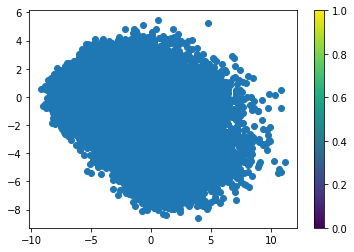

In [83]:
index = 2000
mean,logvar=modelVAE.encoder(x_train[:])
mean = mean.numpy()
a = mean.var(0)
i = np.where(a>0.1)
plt.scatter(mean[:,7],mean[:,8])
# pca = PCA(n_components=2)
# pca_fit = pca.fit(mean)
# points = pca_fit.transform(mean)
# plt.scatter(points[:,0],points[:,1],c=xRe_mean[:index])
plt.colorbar()
print(a)
var = np.exp(logvar)
var.mean(0)


100%|██████████| 16/16 [00:04<00:00,  3.75it/s]


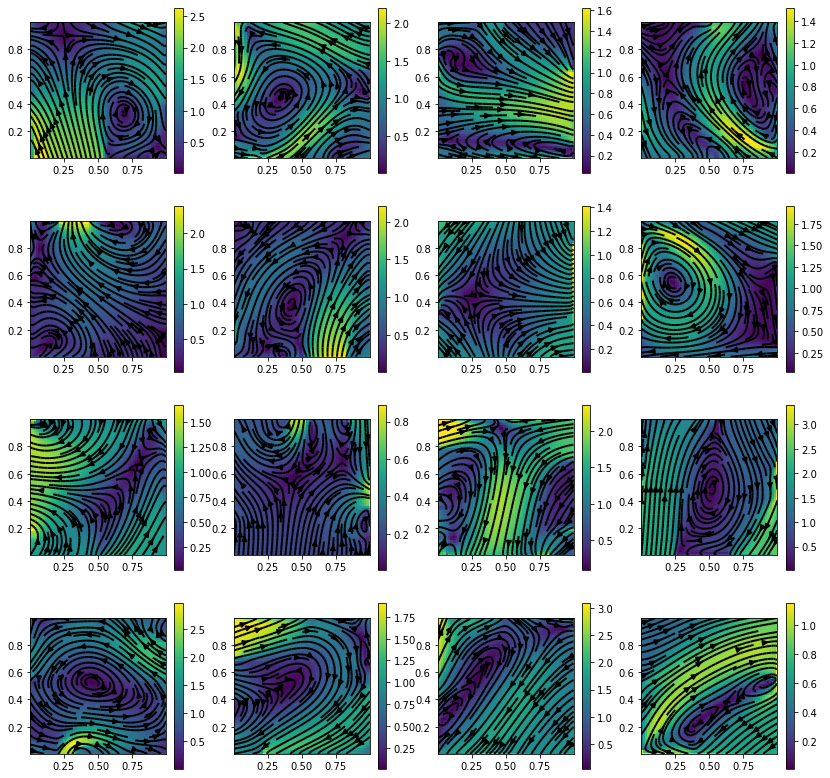

100%|██████████| 16/16 [00:03<00:00,  4.06it/s]


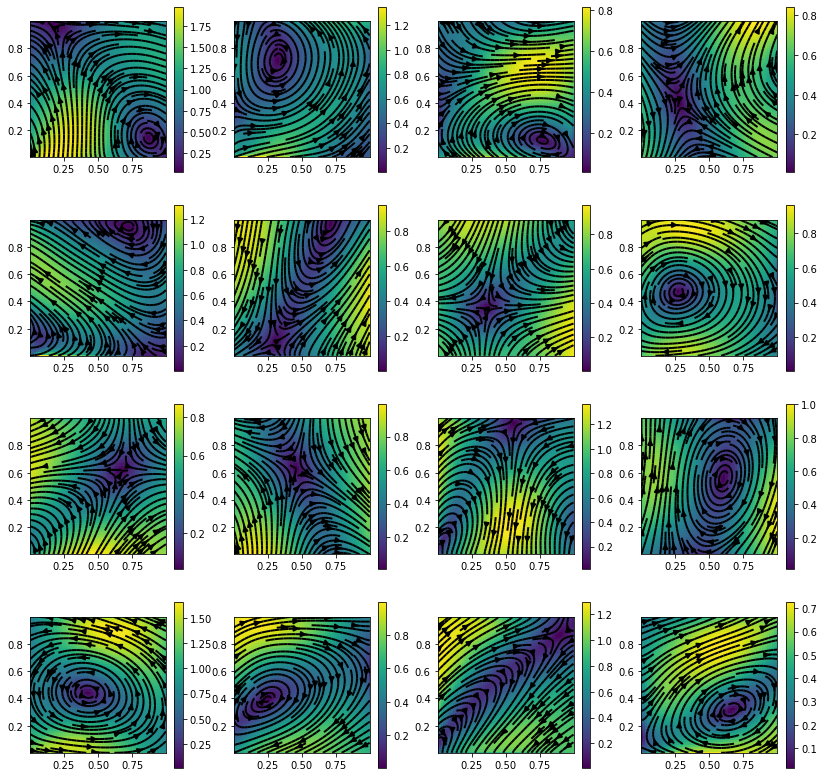

In [82]:
# np.exp(logvar.numpy().mean(0))
prob = sf.GetProblem(30,1)
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
x_train = x_train[indexes]
x_sample = x_train[:]
x_recon = modelVAE.reconstruct(x_sample).numpy()
af.PlotX(4,4,x_sample,prob)
af.PlotX(4,4,x_recon,prob)

100%|██████████| 9/9 [00:02<00:00,  3.67it/s]


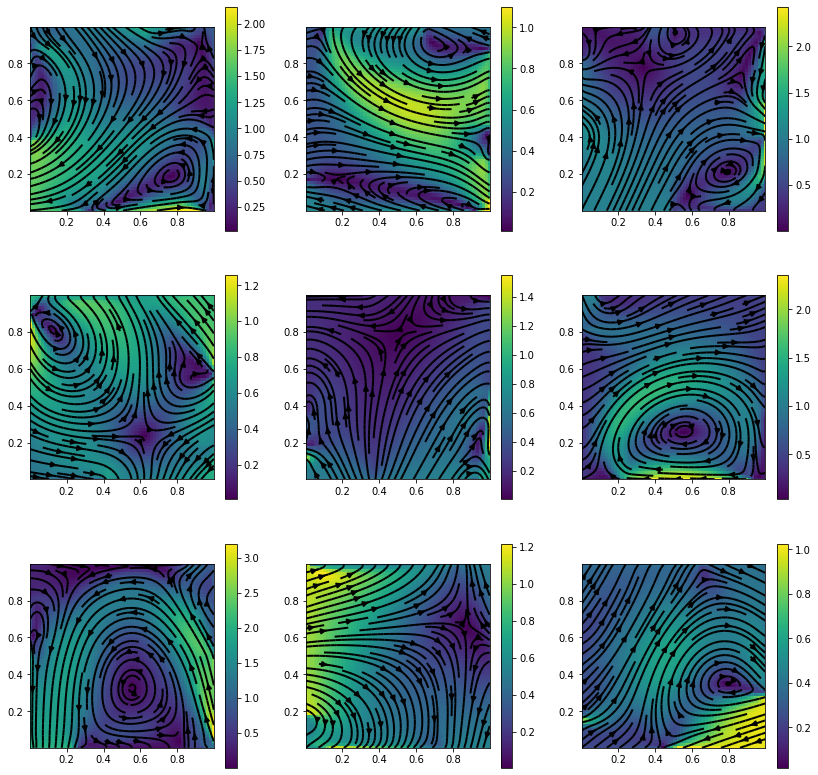

In [42]:
def plotX(x_train,prob):
    X_n,Y_n = prob.X_p,prob.Y_p
    x_lim = (prob.xc_p[0],prob.xc_p[-1])
    y_lim = (prob.yc_p[0],prob.yc_p[-1])
    u_n = x_train[:,:,0]
    v_n = x_train[:,:,1]
    # u_n = np.transpose(u_n)
    # v_n = np.transpose(v_n)
    X,Y = np.meshgrid(np.linspace(x_lim[0],y_lim[-1],u_n.shape[0]*2),np.linspace(y_lim[0],y_lim[-1],u_n.shape[1]*2))
    points_n = np.concatenate([X_n.reshape(X_n.size,1),Y_n.reshape(Y_n.size,1)],axis=1)
    values_n = np.concatenate([u_n.reshape(u_n.size,1),v_n.reshape(v_n.size,1)],axis=1)
    interp = LinearNDInterpolator(points_n, values_n)
    values_i = interp(X,Y)
    u_c = values_i[:,:,0]
    v_c = values_i[:,:,1]
    # ax = plt.subplot(a,b,i+1)
    plt.gca().set_ylim(x_lim)
    plt.gca().set_xlim(y_lim)
    c = plt.pcolormesh(X,Y,np.sqrt(u_c**2+v_c**2))
    plt.colorbar(c)
    plt.streamplot(X,Y,u_c,v_c,color="k",linewidth=2,density=1)
    plt.gca().set_aspect('equal', adjustable='box')

def CompareRecon(modelVAE,modelAE,x_train, a,prob):
    n = min(x_train.shape[0],a)
    x_r_nl = modelVAE.reconstruct(x_train[:n]).numpy()
    x_r_l = modelAE(x_train[:n]).numpy()
    plt.figure(figsize=(10,10))
    for i in tqdm(range(n)):
        plt.subplot(n,3,3*i+1)
        plotX(x_train[i],prob)
        plt.subplot(n,3,3*i+2)
        plotX(x_r_l[i],prob)
        plt.subplot(n,3,3*i+3)
        plotX(x_r_nl[i],prob)
        
        
# CompareRecon(modelVAE,model,x_train[3:],4,prob)
af.PlotX(3,3,x_train[15000:],prob)

In [91]:
def CalcMSE(x_train,model,VAE):
    if VAE:
        x_r = model.reconstruct(x_train).numpy()
    else:
        x_r = model(x_train).numpy()
    mse = np.square(x_train-x_r).mean()
    return mse

mse_nl = CalcMSE(x_train,modelVAE2,True)
mse_l = CalcMSE(x_train,model_l,False)
print(mse_l,mse_nl)

0.40563337534121857 1.5634567327249163


In [70]:
modelVAE2 = ModelVAE_NL(10,(30,30,3))
modelVAE2.load_weights("MLmodels/NS_10D_NLv2")
isinstance(model,Model)

True

In [102]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [78]:
type(modelVAE2) == ModelVAE_NL

True